<a href="https://colab.research.google.com/github/piyushgoel997/MutationClassification/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports


In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.utils import shuffle
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, BatchNormalization, GlobalMaxPooling1D

data_url = "https://raw.githubusercontent.com/piyushgoel997/MutationClassification/master/data.csv"

Using TensorFlow backend.


Load and process data to make matrix

In [2]:
def get_aa_encoder():
    """
    One-hot encoding indices for the 20 possible amino acids.
    :return: the dictionary mapping amino acid to index in the one-hot encoding.
    """
    acids = "ARNDCEQGHILKMFPSTWYV"
    indices = {}
    i = 0
    for a in acids:
        indices[a] = i
        i += 1
    return indices


def make_matrix(seq, alt):
    """
    makes a matrix where each of the 51 features correspond to the amino acid at
    that position in the sequence after the one-hot encoding using the indices
    provided. Also puts a -1 at in the middle most feature at the position
    corresponding to the alt amino acid.
    :param seq: the sequence to be encoded.
    :param alt: the alternate amino acid
    :return: the resultant encoded matrix (51 X 20)
    """
    indices = get_aa_encoder()
    matrix = np.zeros((len(indices), len(seq)))
    i = 0
    for s in seq:
        matrix[indices[s]][i] = 1
        i += 1
    matrix[indices[alt]][int(len(seq) / 2)] = -1
    return matrix.T


def map_description(description):
    map = {'Benign': 0, 'Benign/Likely benign': 0, 'Likely benign': 0,
           'Likely pathogenic': 1, 'Pathogenic': 1, 'Pathogenic/Likely pathogenic': 1}
    return map[description]


X = []
Y = []
mutations = pd.read_csv(data_url)

for _, row in mutations.iterrows():
    X.append(make_matrix(row["REF_SEQ"], row["ALT_AA"]))
    Y.append(map_description(row["DESCRIPTION"]))

X = np.array(X)
Y = np.array(Y)

X, Y = shuffle(X, Y)

print("Input shape", X.shape, "\nOutput shape", Y.shape)

Input shape (229502, 51, 20) 
Output shape (229502,)


In [0]:
def get_model(h=0):
    """
    make, compile and return the model
    :param h: The number of hidden layers with 64 channels to be added
    :return: the model
    """
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation="relu"))
    for _ in range(h):
        model.add(Conv1D(64, kernel_size=5, activation="relu"))
        model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(1, kernel_size=1, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model


def k_fold_cross_validation(h, X, Y, k=10, epochs=20):
    """
    Make the model, train it, and validate it using k-fold cross validation.
    :param h: The number of hidden layers with 64 channels to be added in the model.
    :param X: input to the model.
    :param Y: expected outputs of the model.
    :return: average accuracy, avg auc, k roc curve coordinates, k prc curve coordinates.
    """
    avg_accuracy_tain = 0
    avg_accuracy_val = 0
    avg_loss_train = 0
    avg_loss_val = 0
    avg_roc_auc = 0
    roc_curves = []
    prc_curves = []
    for i in range(k):
        model = get_model(h)
        print("========Cross Validation:", str(i) + "/" + str(k) + "========")
        start = int(X.shape[0] * (i / k))
        end = int(X.shape[0] * ((i + 1) / k))
        test_data = X[start:end]
        y_test = Y[start:end]
        train_data = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([Y[:start], Y[end:]])
        history = model.fit(train_data, y_train, validation_data=(test_data, y_test), epochs=epochs)
        test_out = model.predict(test_data)
        fpr, tpr, _ = roc_curve(y_test, test_out)
        roc_curves.append((fpr, tpr))
        avg_roc_auc += auc(fpr, tpr)
        p, r, _ = precision_recall_curve(y_test, test_out)
        prc_curves.append((p, r))
        avg_accuracy_tain += history.history['accuracy'][-1]
        avg_accuracy_val += history.history['val_accuracy'][-1]
        avg_loss_train += history.history['loss'][-1]
        avg_loss_val += history.history['val_loss'][-1]
        
        del model

    return {"avg_accuracy_train": avg_accuracy_tain / k, "avg_accuracy_val": avg_accuracy_val / k,
            "avg_loss_train": avg_loss_train / k, "avg_loss_val": avg_loss_val / k,
            "avg_roc_auc": avg_roc_auc / k, "roc": roc_curves, "prc": prc_curves}

Training and evaluating 3 different models

==========Starting for h = 1==========
========Cross Validation: 0/5========
Epoch 1/10
5738/5738 [==============================] - 40s 7ms/step - loss: 0.1317 - accuracy: 0.8291 - val_loss: 0.0917 - val_accuracy: 0.8710
Epoch 2/10
5738/5738 [==============================] - 40s 7ms/step - loss: 0.0877 - accuracy: 0.8755 - val_loss: 0.0840 - val_accuracy: 0.8815
Epoch 3/10
5738/5738 [==============================] - 40s 7ms/step - loss: 0.0818 - accuracy: 0.8831 - val_loss: 0.0793 - val_accuracy: 0.8864
Epoch 4/10
5738/5738 [==============================] - 40s 7ms/step - loss: 0.0789 - accuracy: 0.8876 - val_loss: 0.0798 - val_accuracy: 0.8843
Epoch 5/10
5738/5738 [==============================] - 41s 7ms/step - loss: 0.0774 - accuracy: 0.8904 - val_loss: 0.0805 - val_accuracy: 0.8854
Epoch 6/10
5738/5738 [==============================] - 40s 7ms/step - loss: 0.0755 - accuracy: 0.8933 - val_loss: 0.0775 - val_accuracy: 0.8895
Epoch 7/10
5738/5738 [==============================]

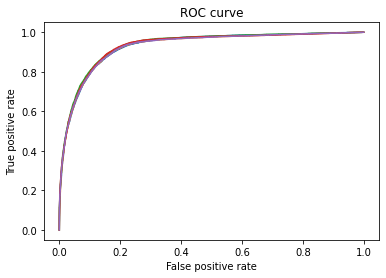

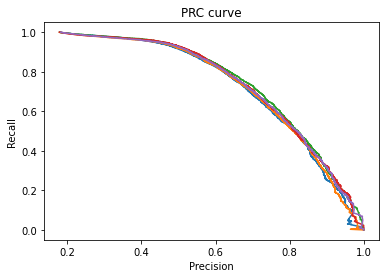

Time taken for this model 2012.5066413879395
===============Finished===============
==========Starting for h = 2==========
========Cross Validation: 0/5========
Epoch 1/10
5738/5738 [==============================] - 47s 8ms/step - loss: 0.1275 - accuracy: 0.8335 - val_loss: 0.0884 - val_accuracy: 0.8762
Epoch 2/10
5738/5738 [==============================] - 47s 8ms/step - loss: 0.0849 - accuracy: 0.8801 - val_loss: 0.0782 - val_accuracy: 0.8881
Epoch 3/10
5738/5738 [==============================] - 46s 8ms/step - loss: 0.0772 - accuracy: 0.8893 - val_loss: 0.0765 - val_accuracy: 0.8892
Epoch 4/10
5738/5738 [==============================] - 46s 8ms/step - loss: 0.0734 - accuracy: 0.8954 - val_loss: 0.0784 - val_accuracy: 0.8900
Epoch 5/10
5738/5738 [==============================] - 47s 8ms/step - loss: 0.0705 - accuracy: 0.9013 - val_loss: 0.0735 - val_accuracy: 0.8955
Epoch 6/10
5738/5738 [==============================] - 46s 8ms/step - loss: 0.0674 - accuracy: 0.9060 - val_loss:

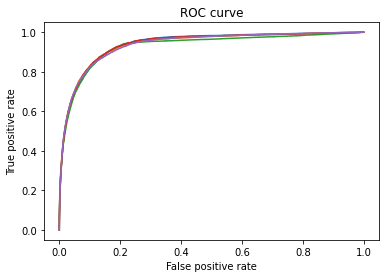

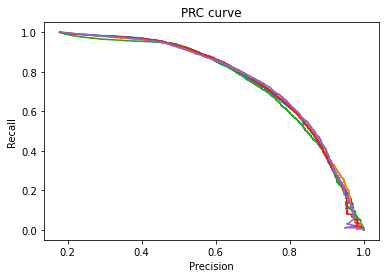

Time taken for this model 2353.626848459244
===============Finished===============
==========Starting for h = 3==========
========Cross Validation: 0/5========
Epoch 1/10
5738/5738 [==============================] - 53s 9ms/step - loss: 0.1195 - accuracy: 0.8421 - val_loss: 0.0900 - val_accuracy: 0.8763
Epoch 2/10
5738/5738 [==============================] - 54s 9ms/step - loss: 0.0825 - accuracy: 0.8842 - val_loss: 0.0794 - val_accuracy: 0.8901
Epoch 3/10
5738/5738 [==============================] - 54s 9ms/step - loss: 0.0759 - accuracy: 0.8934 - val_loss: 0.0752 - val_accuracy: 0.8936
Epoch 4/10
5738/5738 [==============================] - 54s 9ms/step - loss: 0.0715 - accuracy: 0.9006 - val_loss: 0.0723 - val_accuracy: 0.8980
Epoch 5/10
5738/5738 [==============================] - 54s 9ms/step - loss: 0.0679 - accuracy: 0.9069 - val_loss: 0.0711 - val_accuracy: 0.9011
Epoch 6/10
5738/5738 [==============================] - 53s 9ms/step - loss: 0.0647 - accuracy: 0.9127 - val_loss: 

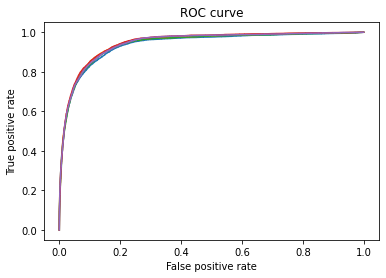

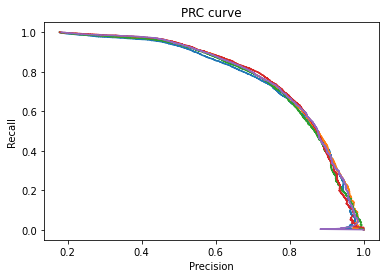

Time taken for this model 2709.5708611011505
===============Finished===============
Total time taken 7075.706096172333
The h value for the best validation accuracy is 3 and the corresponding accuracy is 0.909957206249237
The h value for the best auc is 3 and the corresponding auc is 0.9429237615441686


In [10]:
best_h_acc = -1  # best h value when chosen based on the validation accuracy.
best_acc = 0
best_h_auc = -1  # best h value when chosen based on the validation auc value.
best_auc = 0

over_all_start_time = time.time()

for h in range(1,4):
    start_time = time.time()
    print("==========Starting for h =", str(h) + "==========")

    metrics = k_fold_cross_validation(h, X, Y, k=5, epochs=10)

    print("Final metrics for this model")
    print("Average of the final training set accuracy over all folds =", str(metrics["avg_accuracy_train"]))
    print("Average of the final training set loss over all folds =", str(metrics["avg_loss_train"]))
    print("Average of the final validation set accuracy over all folds =", str(metrics["avg_accuracy_val"]))
    print("Average of the final validation set accuracy over all folds =", str(metrics["avg_loss_val"]))
    print("Average of the ROC AUC over all folds =", str(metrics["avg_roc_auc"]))

    for c in metrics["roc"]: plt.plot(*c)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()

    for c in metrics["prc"]: plt.plot(*c)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('PRC curve')
    plt.show()

    if metrics["avg_accuracy_val"] > best_acc:
        best_h_acc = h
        best_acc = metrics["avg_accuracy_val"]

    if metrics["avg_roc_auc"] > best_auc:
        best_h_auc = h
        best_auc = metrics["avg_roc_auc"]

    print("Time taken for this model", str(time.time() - start_time))

    print("===============Finished===============")

print("Total time taken", str(time.time() - over_all_start_time))
print("The h value for the best validation accuracy is", str(best_h_acc), "and the corresponding accuracy is",
      str(best_acc))
print("The h value for the best auc is", str(best_h_auc), "and the corresponding auc is", str(best_auc))

Now training the best model architecture using the whole data

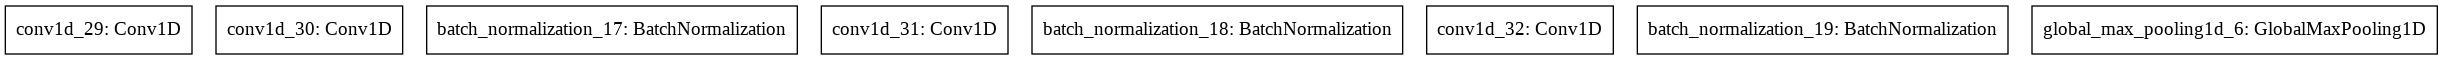

In [18]:
model = get_model(best_h_acc)
X, Y = shuffle(X, Y)

history = model.fit(X, Y, epochs=20)

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plot_model(model, to_file='model.png')

model.summary()

model.save("model.h5")